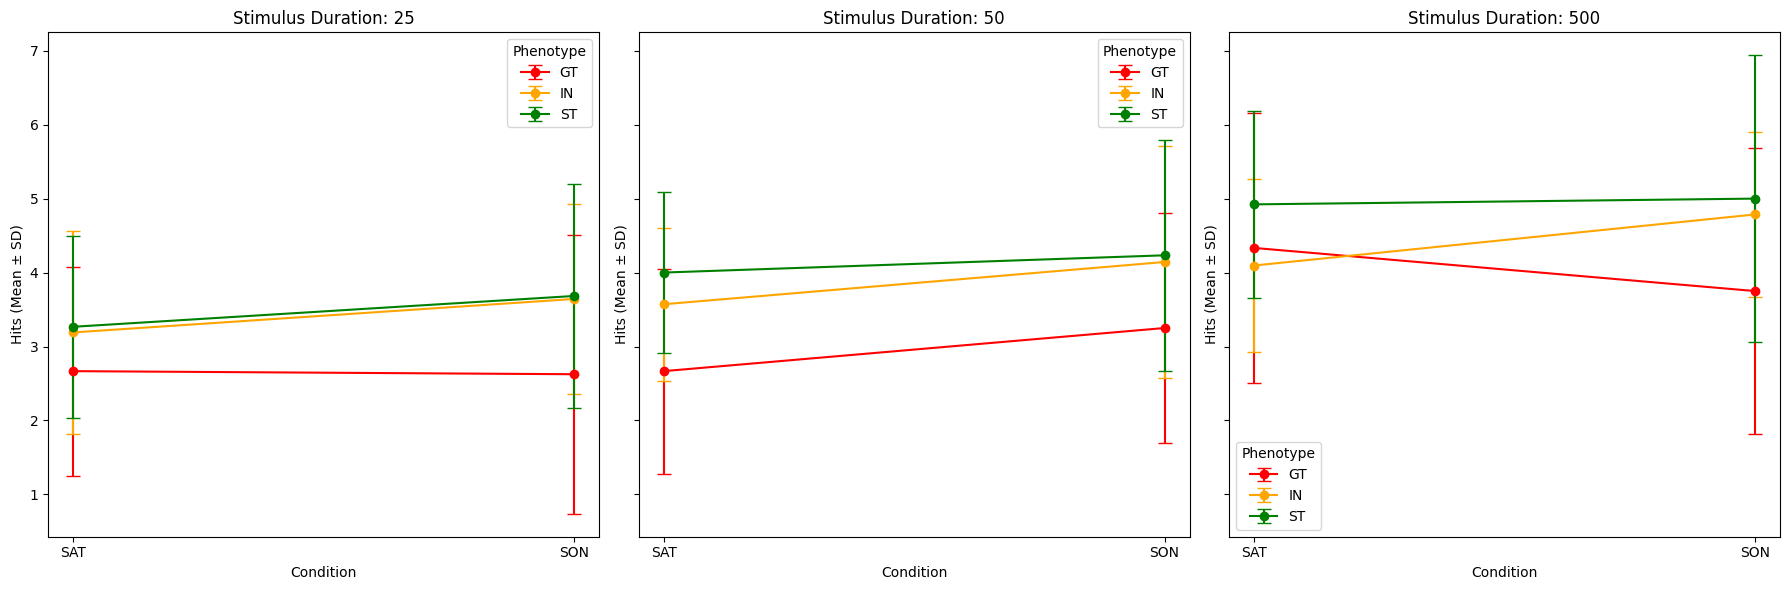

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load the Excel file and list the sheet names to locate the 'tidy' sheet
file_path = 'SATson1.xlsx'
excel_data = pd.ExcelFile(file_path)

# Check sheet names
excel_data.sheet_names
# Load the 'tidy' sheet into a DataFrame
tidy_df = pd.read_excel(file_path, sheet_name='tidy')

# Display the first few rows of the data to understand its structure
tidy_df.head()

# Grouping the data to calculate mean and standard deviation for each phenotype, condition, and stimulus duration
summary_df = tidy_df.groupby(['phenotype', 'stimulus_duration', 'condition']).agg(
    hits_mean=('hits', 'mean'),
    hits_sd=('hits', 'std')
).reset_index()

# Now, I'll create the line graphs as requested
import matplotlib.pyplot as plt

# Define colors for the phenotypes
colors = {'ST': 'green', 'IN': 'orange', 'GT': 'red'}

# Create a function to plot the graphs for each stimulus duration
def plot_graphs_for_stimulus(stimulus_duration, ax):
    # Filter the data for the current stimulus duration
    data = summary_df[summary_df['stimulus_duration'] == stimulus_duration]
    
    for phenotype in data['phenotype'].unique():
        phenotype_data = data[data['phenotype'] == phenotype]
        
        # Plotting the mean line with error bars for SD
        ax.errorbar(phenotype_data['condition'], 
                    phenotype_data['hits_mean'], 
                    yerr=phenotype_data['hits_sd'], 
                    label=phenotype, 
                    color=colors[phenotype], 
                    capsize=5, 
                    marker='o')
        
    ax.set_title(f'Stimulus Duration: {stimulus_duration}')
    ax.set_xlabel('Condition')
    ax.set_ylabel('Hits (Mean ± SD)')
    ax.legend(title="Phenotype")

# Creating side-by-side plots for each stimulus duration
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for stimulus durations 25, 50, and 500
for i, duration in enumerate([25, 50, 500]):
    plot_graphs_for_stimulus(duration, axs[i])

plt.tight_layout()
plt.show()


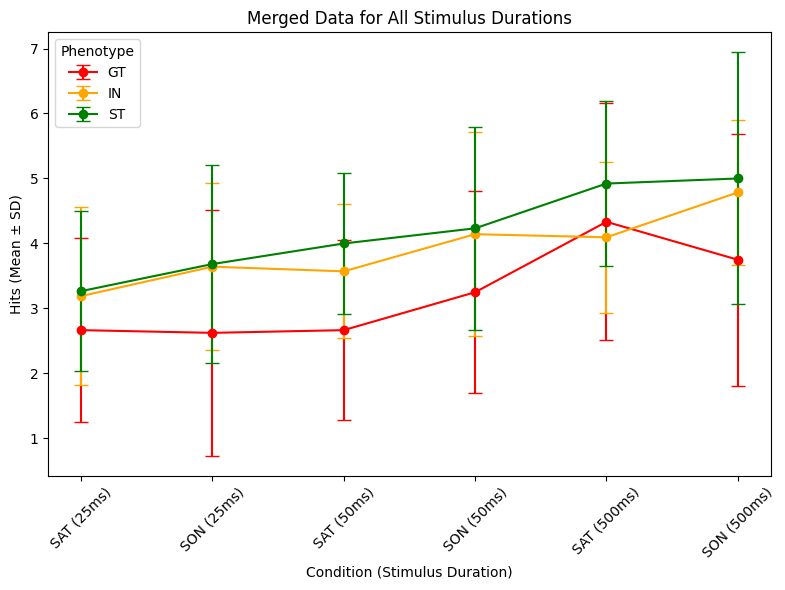

In [3]:
# Creating a merged plot with all stimulus durations in one graph
fig, ax = plt.subplots(figsize=(8, 6))

for phenotype in summary_df['phenotype'].unique():
    # Filter data by phenotype
    phenotype_data = summary_df[summary_df['phenotype'] == phenotype]
    
    # Plot the mean line with error bars for SD, including all stimulus durations
    ax.errorbar(phenotype_data['condition'] + " (" + phenotype_data['stimulus_duration'].astype(str) + "ms)", 
                phenotype_data['hits_mean'], 
                yerr=phenotype_data['hits_sd'], 
                label=phenotype, 
                color=colors[phenotype], 
                capsize=5, 
                marker='o')

ax.set_title('Merged Data for All Stimulus Durations')
ax.set_xlabel('Condition (Stimulus Duration)')
ax.set_ylabel('Hits (Mean ± SD)')
ax.legend(title="Phenotype")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


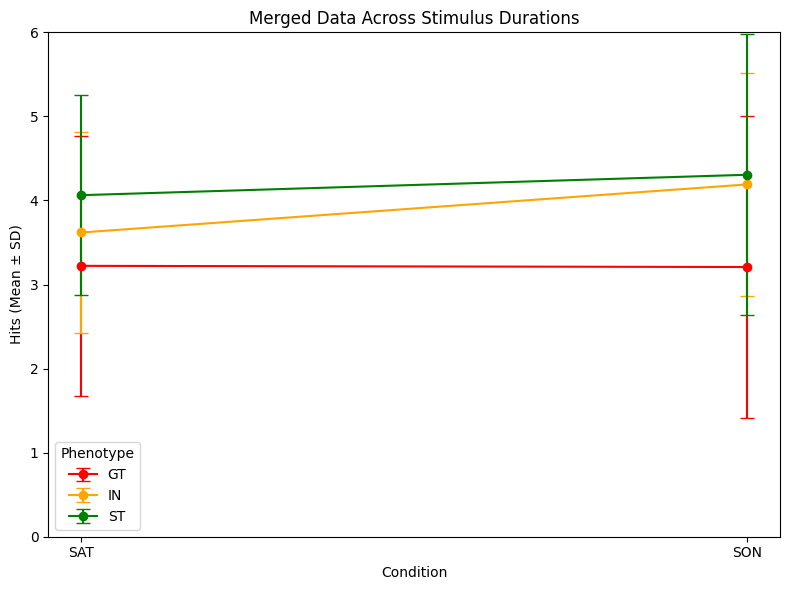

In [3]:
# Now, let's compute the mean across stimulus durations for each phenotype and condition
merged_summary_df = summary_df.groupby(['phenotype', 'condition']).agg(
    hits_mean=('hits_mean', 'mean'),
    hits_sd=('hits_sd', 'mean')  # Merging SD by averaging as well
).reset_index()

# Creating a new plot for the merged stimulus durations
fig, ax = plt.subplots(figsize=(8, 6))

for phenotype in merged_summary_df['phenotype'].unique():
    # Filter data by phenotype
    phenotype_data = merged_summary_df[merged_summary_df['phenotype'] == phenotype]
    
    # Plot the mean line with error bars for SD
    ax.errorbar(phenotype_data['condition'], 
                phenotype_data['hits_mean'], 
                yerr=phenotype_data['hits_sd'], 
                label=phenotype, 
                color=colors[phenotype], 
                capsize=5, 
                marker='o')

ax.set_title('Merged Data Across Stimulus Durations')
ax.set_xlabel('Condition')
ax.set_ylabel('Hits (Mean ± SD)')
ax.legend(title="Phenotype")
plt.ylim(0, 6)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import pingouin as pg

# Load your dataset
file_path = 'SATson1.xlsx'  # Replace with your actual file path
tidy_df = pd.read_excel(file_path, sheet_name='tidy')

# Filtering necessary columns for analysis
hits_df = tidy_df[['phenotype', 'animal_id', 'stimulus_duration', 'condition', 'hits']]



# Filtering necessary columns for analysis (focus on phenotype and condition)
hits_df = tidy_df[['phenotype', 'animal_id', 'condition', 'hits']]

# Running the mixed-design ANOVA
anova_results = pg.mixed_anova(
    dv='hits', 
    within='condition', 
    between='phenotype', 
    subject='animal_id', 
    data=hits_df
)

# Calculate generalized eta-squared for effect sizes


# Print ANOVA results
print("ANOVA Results:\n", anova_results)

# Check for significant factors and run Bonferroni post-hoc tests if needed
significant_factors = anova_results[anova_results['p-unc'] < 0.05]['Source'].tolist()

if significant_factors:
    post_hocs = pg.pairwise_ttests(
        dv='hits', 
        within='condition', 
        between='phenotype', 
        subject='animal_id', 
        data=hits_df, 
        padjust='bonferroni'
    )
    print("\nPost-hoc Results (Bonferroni corrected):\n", post_hocs)
else:
    print("\nNo significant factors found.")


ANOVA Results:
         Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0    phenotype  9.727681    2   19  4.863840  2.433714  0.114553  0.203936   
1    condition  1.401172    1   19  1.401172  5.084423  0.036134  0.211108   
2  Interaction  0.404791    2   19  0.202396  0.734432  0.492911  0.071761   

   eps  
0  NaN  
1  1.0  
2  NaN  

Post-hoc Results (Bonferroni corrected):
                 Contrast condition    A    B Paired Parametric         T  \
0              condition         -  SAT  SON   True       True -2.283934   
1              phenotype         -   GT   IN  False       True -0.712069   
2              phenotype         -   GT   ST  False       True -1.278539   
3              phenotype         -   IN   ST  False       True -1.058355   
4  condition * phenotype       SAT   GT   IN  False       True -0.444414   
5  condition * phenotype       SAT   GT   ST  False       True -1.177584   
6  condition * phenotype       SAT   IN   ST  False       Tr

C:\Users\pfh3221\AppData\Roaming\Python\Python38\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
